# A tour of navground

In this tour you meet the basic components of the navigation playground 
and see them at play.

At the core of the playground there is a library of navigation behaviors for dynamic obstacle avoidance. 

Let's import the library and instantiate one of the behavior ([DummyBehavior](../reference/core/python/behaviors/dummy.html#navground.core.behaviors.DummyBehavior)).

## Behaviors

In [1]:
from navground import core

behavior = core.behaviors.DummyBehavior()

A behavior holds the **2D state of an agent** of circular shape.

We set

- the [pose](../reference/core/python/common.html#navground.core.Pose2)
of the agent at the origin of the world-fixed coordinate frame,

In [2]:
behavior.pose = core.Pose2(position=(0, 0), orientation=0)

- the [twist](../reference/core/python/common.html#navground.core.Twist2) of the agent to zero,

In [3]:
behavior.twist = core.Twist2(velocity=(0, 0), angular_speed=0)

- and the radius of the agent.

In [4]:
behavior.radius = 1.0

A behavior needs also a [target](../reference/core/python/target.html#navground.core.Target): let's go to ``(10, 0)``, stopping when near enough.

In [5]:
behavior.target = core.Target.Point((10, 0), tolerance=0.5)

Once we have set a target, we can ask for a [control command](../reference/core/python/behaviors/behavior.html#navground.core.Behavior.compute_cmd) (a twist) to advance towards the target in the next control step.

In [6]:
behavior.compute_cmd(time_step=0.1)

Missing kinematics!


Twist2((0.000000, 0.000000), 0.000000, frame=Frame.relative)

Oops ... the behavior is complaining that it does not know the kinematics of the agent.
Therefore, it plays safe and makes the agent stay in place. We also see that `Twist2` has an additional field `Twist2(..., frame)` for the reference frame, which can be either an absolute world-fixed frame or a relative frame attached to to the agent.

A [kinematics](../reference/core/python/kinematics.html#navground.core.Kinematics) model knows the maximal speed of the agent and, more generally, which commands are feasible.
Let's pick an omnidirectional kinematics that has no restrictions apart from maximal horizontal and angular speeds,

In [7]:
kinematics = core.kinematics.OmnidirectionalKinematics(max_speed=2.0, max_angular_speed=1.0)
behavior.kinematics = kinematics

and ask again for a control command.

In [8]:
cmd = behavior.compute_cmd(time_step=0.1)
cmd

Twist2((2.000000, 0.000000), 0.000000, frame=Frame.relative)

As expected, the behavior wants to advance full speed towards the target point.
How to actuate the commands depends on the agent we are controlling and may require interacting with the agent's runtime.

Here, we keep it simple and simulate movements without any error: we apply the command for a time step to directly update the behavior state.

In [9]:
behavior.actuate(cmd, time_step=0.1)

To get the same result, we could have manually integrated the pose and set the twist.

In [10]:
behavior.pose = behavior.pose.integrate(cmd, time_step=0.1)
behavior.twist = cmd

Note that behaviors are already instantiated at the origin and with zero twist, therefore
we could have setup the behavior using just two lines:

In [11]:
behavior = core.behaviors.DummyBehavior(kinematics=kinematics, radius=1.0)
behavior.target = core.Target.Point((10, 0), tolerance=0.5)

## Registers

What if our agent has wheels? Which other kinematics are there? 

Implemented kinematics are stored in a register. Let's list their names:

In [12]:
core.Kinematics.types

['2WDiff', '2WDiffDyn', '4WOmni', 'Ahead', 'Omni']

`"Omni"` is the one we already used. Let's pick `"2WDiff"`, which corresponds to a robot with two differential drive wheels, one at each side of a longitudinal axis.

In [13]:
kinematics = core.Kinematics.make_type("2WDiff")
kinematics.max_speed = 1.0

Registered components, like kinematics, declare properties that we can use to configure them.
Let's get all properties of this kinematics model.

In [14]:
for name, p in kinematics.properties.items():
    print(f'Property {name}: {p.description} of type {p.type_name}')

Property max_backward_speed: Maximal backward linear speed of type float
Property max_forward_speed: Maximal forward linear speed of type float
Property wheel_axis: Wheel Axis of type float


We set the wheel axis length to the size of the agent.

In [15]:
kinematics.set("wheel_axis", 2.0)

Note that instantiating a kinematics from a register and configuring through its properties, like we have just done, is equivalent to an explicit instantiation like

In [16]:
kinematics = core.kinematics.TwoWheelsDifferentialDriveKinematics(max_speed=1.0, wheel_axis=2.0)

Let's now get a command that respects this kinematics,

In [17]:
behavior.kinematics = kinematics 
cmd = behavior.compute_cmd(time_step=0.1)
cmd

Twist2((1.000000, 0.000000), 0.000000, frame=Frame.relative)

which we can convert to left and right wheel speeds.

In [18]:
behavior.kinematics.wheel_speeds(cmd)

[1.0, 1.0]

Again and unsurprisingly, the behavior wants to set both wheels at the same maximal speed to advance straight at full speed.

## Trajectory

Applying the control step iteratively, we make the agent reach the target point, while we also store its position to later plot the trajectory.

In [19]:
import numpy as np

positions = []

time_step = 0.1

while not behavior.check_if_target_satisfied():
    positions.append(behavior.position)
    cmd = behavior.compute_cmd(time_step=time_step)
    behavior.actuate(cmd, time_step=time_step)
    
positions = np.asarray(positions)

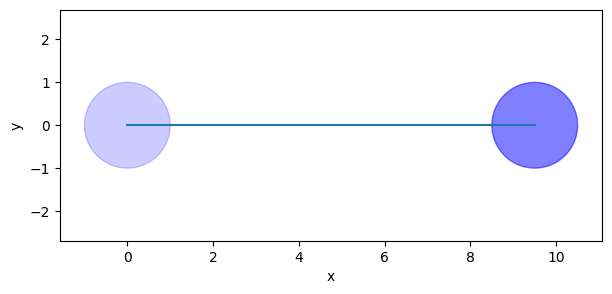

In [20]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=((7, 3)))
ax.add_patch(plt.Circle(positions[0], behavior.radius, color='blue', alpha=0.2))
ax.add_patch(plt.Circle(positions[-1], behavior.radius, color='blue', alpha=0.5))
# ax.add_patch(plt.Circle(behavior.target.position, behavior.target.position_tolerance, color='red', alpha=0.6, fill=False))
ax.plot(positions[:, 0], positions[:, 1], '-')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.axis('equal');

We got the trajectory we expected, altough not a particularly interesting one.

## Environment state

The job of the behavior is to navigate the agent through obstacles. So let's add a round obstacle in the middle of the agent's path.

In [21]:
disc = core.Disc(position=(5.0, 0.1), radius=1)

How do we tell the behavior to avoid the obstacle?
For this, each behavior keeps an environmental state ... unfortunately our current behavior, 
as we may expect from a behavior called *Dummy*, does not have one.

In [22]:
behavior.environment_state is None

True

So, let's switch to a smarter behavior. Like for kinematics, behaviors are registered by name

In [23]:
core.Behavior.types

['', 'Dummy', 'HL', 'HRVO', 'ORCA', 'PyDummy', 'SocialForce']

We pick `"ORCA"` and setup it with the same kinematics, state, and target as before.

In [24]:
behavior = core.Behavior.make_type('ORCA')
behavior.kinematics = kinematics
behavior.pose = core.Pose2((0, 0), 0)
behavior.twist = core.Twist2((0, 0), 0)
behavior.radius = 1.0
behavior.target = core.Target.Point((10, 0), tolerance=0.5)

This behavior has a more useful environment state which contains static obstacles:

In [25]:
behavior.environment_state.static_obstacles = [disc]

Let's check that the behavior is really considering the obstacle:

In [26]:
behavior.compute_cmd(0.1)

Twist2((0.150420, 0.000000), -0.224969, frame=Frame.relative)

In fact, the behavior is telling us to steer clockwise to avoid the obstacle. Let's plot the new trajectory.

In [27]:
positions = []

while not behavior.target.satisfied(behavior.pose):
    positions.append(behavior.position)
    cmd = behavior.compute_cmd(0.1)
    behavior.actuate(cmd, 0.1)
    
positions = np.asarray(positions)

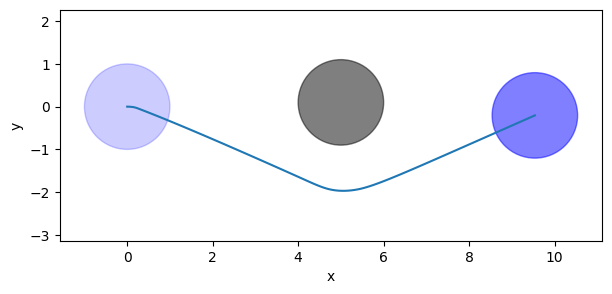

In [28]:
fig, ax = plt.subplots(figsize=((7, 3)))
ax.add_patch(plt.Circle(disc.position, disc.radius, color='k', alpha=0.5))
ax.add_patch(plt.Circle(positions[0], behavior.radius, color='blue', alpha=0.2))
ax.add_patch(plt.Circle(positions[-1], behavior.radius, color='blue', alpha=0.5))
ax.plot(positions[:, 0], positions[:, 1], '-')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.axis('equal');

Indeed, the agent does a more interesting trajectory!

## Controllers

Controllers monitor a behavior to report when it has reached a target.

Let's try again the same scenario but now using a controller. 

In [29]:
behavior.pose = core.Pose2((0, 0), 0)
behavior.twist = core.Twist2((0, 0), 0)
controller = core.Controller(behavior)

We can tell the control to direcly actuate each control commands in a callback.

In [30]:
time_step = 0.1

def actuate(cmd):
    behavior.actuate(cmd, time_step=time_step)

controller.set_cmd_cb(actuate)

Targets are now set through the controller that returns an *action*,

In [31]:
action = controller.go_to_pose(core.Pose2((10, 0), 3.14), 0.1, 0.1)

which we can use to setup a terminal callback.

In [32]:
action.done_cb = lambda action_state: print(f"Action has finished with {action_state}.")

Commands are now queried through the controller which in turns monitors the action state. The run-loop becomes simpler as we need just a single line per step (in addition to the usual line to store the trajectory).

In [33]:
positions = []

while not controller.idle:
    controller.update(time_step=time_step)
    positions.append(behavior.position)
    
positions = np.asarray(positions)

Action has finished with State.success.


## More agents

Within the playground, we can play with more than a single agent.
Let's add a second agent with the same shape, kinematics, and type of behavior.

In [34]:
behavior_1 = core.Behavior.make_type("ORCA")
behavior_1.radius = 1.0
behavior_1.kinematics = kinematics
behavior_2 = core.Behavior.make_type("ORCA")
behavior_2.radius = 1.0
behavior_2.kinematics = kinematics
behaviors = [behavior_1, behavior_2]

We want to make them cross. Let them start from opposing poses

In [35]:
behavior_1.pose = core.Pose2((0, 0), 0)
behavior_2.pose = core.Pose2((10, 0), np.pi)

and then exchange positions.

In [36]:
behavior_1.target = core.Target.Point(behavior_2.position, 0.1)
behavior_2.target = core.Target.Point(behavior_1.position, 0.1)

We need to tell the behaviors that there is another agent in their vicinity, a *neighbor*.

Neighbors are also of circular shape and their state consists of position, radius, and velocity.
For real agents, environment state would originate from perception, which may be noisy and have partial visibility.
Here, we keep it simple and make the agents aware of all other agents, adding all of them as neighbors in a perfectly accurate environment state.

In [37]:
for behavior in behaviors:
    behavior.environment_state.neighbors = [
        core.Neighbor(position=b.position, radius=b.radius, velocity=b.velocity)
        for b in behaviors if b is not behavior
    ]

Let's try again to compute the trajectories. Contrary to static obstacles, neighbors ... do move. 
Therefore, we need to update them before asking for a new control commands.

In [38]:
positions = []
time_step = 0.1

while not all(b.target.satisfied(b.pose) for b in behaviors):
    positions.append([b.position for b in behaviors])
    cmds = []
    for behavior in behaviors:
        behavior.environment_state.neighbors = [
            core.Neighbor(position=b.position, radius=b.radius, velocity=b.velocity)
            for b in behaviors if b != behavior
        ]
        cmds.append(behavior.compute_cmd(time_step=time_step))
    for behavior, cmd in zip(behaviors, cmds):
        behavior.actuate(cmd, time_step=time_step)
    
positions = np.asarray(positions)

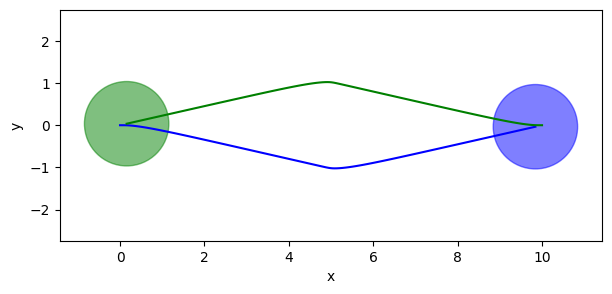

In [39]:
fig, ax = plt.subplots(figsize=((7, 3)))
for i, (behavior, color) in enumerate(zip(behaviors, 'bg')):
    ax.add_patch(plt.Circle(positions[-1, i], behavior.radius, color=color, alpha=0.5))
    ax.plot(positions[:, i, 0], positions[:, i, 1], '-', color=color)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.axis('equal');

We see how the two agents successfull avoid a collision and manage to exchange positions.

This concludes the tour of the core part of the playground. 
It you want to integrate some of its components in your system, go ahead 
and skip the rest of the tour, which goes deeper into simulation.

## Simulation

We have seen how to manually write a run-loop to simulate a trajectory.
The playground simplifies this process using `Agent`, `StateEstimation` and `Task`,
which generalize the functionalities we have been implementing.

An agent holds a behavior and a kinematics.

In [40]:
from navground import sim

agent = sim.Agent()
agent.behavior = core.Behavior.make_type('ORCA')
agent.kinematics = core.kinematics.TwoWheelsDifferentialDriveKinematics(max_speed=1.0, wheel_axis=2.0)
agent.pose = core.Pose2((0, 0), 0)
agent.twist = core.Twist2((0, 0), 0)
agent.radius = 1.0

An agent also has a *task* to generate navigation targets. Let's pick ``WaypointsTask`` to ask the agent to pendle between two points.

In [41]:
agent.task = sim.tasks.WaypointsTask(waypoints=[(10, 0), (0, 0)], loop=True, tolerance=0.1)

Finally, an agent uses a *state estimation* to update the ... its behavior environment *state*. 

In [42]:
agent.state_estimation = sim.state_estimations.BoundedStateEstimation(range=5.0)

Let's now add the agent to a world, together with the same static obstacle we have been using.

In [43]:
world = sim.World()
world.add_obstacle(disc)
world.add_agent(agent)

That's all we have to do to setup our simulation. 

Let's run it for a while.

In [44]:
world.run(steps=10, time_step=0.1)

Nice ... but we would like to plot the trajectory again.

We can iteratively run the simulation one step at time while accumulating data

In [45]:
positions = []
for i in range(100):
    world.run(steps=1, time_step=0.1)
    positions.append([a.position for a in world.agents])

or we can add a callback where to accumulate data.

In [46]:
def cb() -> None:
    positions.append([a.position for a in world.agents])

world.add_callback(cb)

We perform additional steps to reach a total of 250 steps:

In [47]:
world.run_until(lambda: world.step >= 250, 0.1)

Let's plot the resulting trajectory.

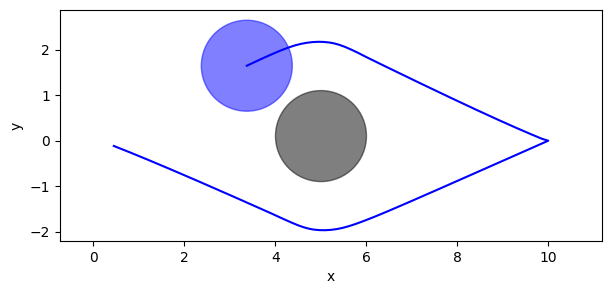

In [48]:
ps = np.asarray(positions)

fig, ax = plt.subplots(figsize=((7, 3)))
ax.add_patch(plt.Circle(disc.position, disc.radius, color='k', alpha=0.5))
for i in range(ps.shape[1]):
    ax.plot(ps[:, i, 0], ps[:, i, 1], 'b-')
    ax.add_patch(plt.Circle(ps[-1, i], behavior.radius, color='b', alpha=0.5))
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.axis('equal');

## Experiment

Instead of manually injecting data collection in the run-loop, we can configure an ``Experiment`` to do it automatically.

Let's start by defining a scenario, which is an object that initializes worlds, grouping together the commands we have been using.

In [49]:
from typing import Optional

class MyScenario(sim.Scenario):

    def __init__(self):
        super().__init__()
    
    def init_world(self, world: sim.World, seed: Optional[int] = None) -> None:
        super().init_world(world, seed)
        agent = sim.Agent()
        agent.behavior = core.Behavior.make_type('ORCA')
        agent.kinematics = core.kinematics.TwoWheelsDifferentialDriveKinematics(max_speed=1.0, wheel_axis=2.0)
        agent.pose = core.Pose2((0, 0), 0)
        agent.twist = core.Twist2((0, 0), 0)
        agent.radius = 1.0
        agent.task = sim.tasks.WaypointsTask(waypoints=[(10, 0), (0, 0)], loop=True, tolerance=0.1)
        agent.state_estimation = sim.state_estimations.BoundedStateEstimation(range=5.0)
        world.add_obstacle(core.Disc(position=(5.0, 0.1), radius=1))
        world.add_agent(agent)

Then, we configure an experiment to run such scenario for some steps. 

In [50]:
experiment = sim.Experiment()
experiment.scenario = MyScenario()
experiment.time_step = 0.1
experiment.steps= 300

We are interested to record poses,

In [51]:
experiment.record_config.pose = True

so let's run the experiment.

In [52]:
run = experiment.run_once(seed=0)

The experiment recorded metadata such as duration,

In [53]:
run.duration

datetime.timedelta(microseconds=436)

as well as the agents' trajectory, as an array of `steps x agents x 3` coordinates.

In [54]:
run.poses.shape

(300, 1, 3)

Optionally, we can configure the experiment to automatically save all data to an HDF5 file.

In [55]:
import h5py
import pathlib

experiment.number_of_runs = 1
experiment.save_directory = pathlib.Path('.')

# experiment.run()
# if experiment.path:
#     data = h5py.File(pathlib.Path(experiment.path))
#     data    

## YAML

What we configured in Python during this tutorial, can be configured in YAML too.

For instance, let's configure the previous experiment using YAML. 
We add our lonely agent in one of the `scenario/groups`.

In [56]:
yaml = """
time_step: 0.1
steps: 300
record_pose: true
scenario:
    obstacles:
        - position: [5, 0.1]
          radius: 1.0
    groups:
        - number: 1
          type: thymio
          behavior:
            type: ORCA
          kinematics:
            type: 2WDiff
            wheel_axis: 2
            max_speed: 1
          task:
            type: Waypoints
            loop: true
            tolerance: 0.1
            waypoints: [[10, 0], [0, 0]]
          state_estimation:
            type: Bounded
            range: 5
          position: [0, 0]
          orientation: 0
          radius: 1.0
          control_period: 0.1        
"""

In [57]:
experiment = sim.load_experiment(yaml)
run = experiment.run_once(seed=1)

YAML is also useful to display a readable representation. Let's try to look at world at the end of the experiment:



In [58]:
print(sim.dump(run.world))

obstacles:
  - position:
      - 5
      - 0.10000000000000001
    radius: 1
    uid: 1
walls:
  []
agents:
  - behavior:
      type: ORCA
      effective_center: false
      max_neighbors: 1000
      static_time_horizon: 10
      time_horizon: 10
      treat_obstacles_as_agents: true
      optimal_speed: 1
      optimal_angular_speed: 1
      rotation_tau: 0.5
      safety_margin: 0
      horizon: 5
      path_look_ahead: 1
      path_tau: 0.5
      radius: 1
      heading: velocity
      kinematics:
        type: 2WDiff
        max_backward_speed: 0
        max_forward_speed: .inf
        wheel_axis: 2
        max_speed: 1
        max_angular_speed: .inf
      social_margin:
        modulation:
          type: constant
        default: 0
    kinematics:
      type: 2WDiff
      max_backward_speed: 0
      max_forward_speed: .inf
      wheel_axis: 2
      max_speed: 1
      max_angular_speed: .inf
    task:
      type: Waypoints
      loop: true
      random: false
      tolerance: 0.

## Real-time simulation

This last part is possibly the most rewarding of the tour. 

Let's try to visualize a simulation while it runs directly in the notebook. For this, you need to install the Python websockets package
```
pip install websockets
```
and be able to listen to port 8000. If you are running it in binder, it won't work as the port won't be exposed. 
Therefore, as an alternative, which works even if you are visualizing this notebook without running it, we can make a video. For this, you need to install cairosvg (to render SVGs) and moviepy (to generate the videos)

```
pip install cairosvg moviepy
```

Let's now display a video of the simulation we just run (speeded up 5x).

In [59]:
from navground.sim.ui.video import display_video_from_run

display_video_from_run(run, factor=5)

Let's go back to the live visualization in the notebook which uses websockets, javascript, and SVG.

In [60]:
from navground.sim.ui import WebUI
from navground.sim.notebook import notebook_view
from navground.sim.real_time import RealTimeSimulation

web_ui = WebUI(host='127.0.0.1', max_rate=-1)
await web_ui.prepare()

True

In [61]:
notebook_view(width=300)

In [62]:
# we run 5x faster than real-time
world = run.world
rt_sim = RealTimeSimulation(world=world, time_step=0.1, factor=5, web_ui=web_ui, 
                            bounds=((-1, -3), (11, 3)))
await rt_sim.init()

In [64]:
until_time = world.time + 60
await rt_sim.run(until=lambda : world.time > until_time)